## Imports and Preprocess

In [379]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(15,5)})

In [380]:
def calculate_corr_ci(df1, df2, alpha=0.05):
    correlations = []
    ci_lower = []
    ci_upper = []

    for column in df1.columns:
        r, _ = stats.pearsonr(df1[column], df2[column])
        r_z = np.arctanh(r)
        se = 1/np.sqrt(df1[column].size-3)
        z = stats.norm.ppf(1-alpha/2)
        lo_z, hi_z = r_z-z*se, r_z+z*se
        lo, hi = np.tanh((lo_z, hi_z))

        correlations.append(r)
        ci_lower.append(lo)
        ci_upper.append(hi)

    return correlations, ci_lower, ci_upper

Read result files

In [381]:
users = pd.read_csv('results/Calibrated Predictions Survey - users.csv', index_col='id')
preds = pd.read_csv('results/Calibrated Predictions Survey - predictions.csv', index_col='id')
labels = pd.read_csv('results/Calibrated Predictions Survey - labels.csv', index_col='id')
pred_test = pd.read_csv('results/Calibrated Predictions Survey - pred_test.csv', index_col='id')
label_test = pd.read_csv('results/Calibrated Predictions Survey - outcome_test.csv', index_col='id')
first_rate = pd.read_csv('results/Calibrated Predictions Survey - first_rate.csv', index_col='id')
last_rate = pd.read_csv('results/Calibrated Predictions Survey - last_rate.csv', index_col='id')

Replace values in data

In [382]:
preds_outcome = preds.applymap(lambda x: 1 if x >= 50 else 0)

map = {"Yes": 1, "No": 0}
label_test = label_test.applymap(lambda x: map.get(x, -1))

Get every model indexes

In [383]:
# get all unique models names in users that start with 'NN'
all_models_names = users['model_name'].unique()

print(all_models_names)
all_models_names = all_models_names[~pd.isnull(all_models_names)]
models_names = [model for model in all_models_names if model.startswith('NN')]
model_names = models_names.sort()
model_indexes = {}

# get indexes of every model name
for model in models_names:
    model_indexes[model] = users.index[users['model_name'] == model].tolist()

['NN' 'NN_IR_PT_Random' 'NN_PT' 'NN_IR' 'NN_IR_PT']


## Average users trust in the system

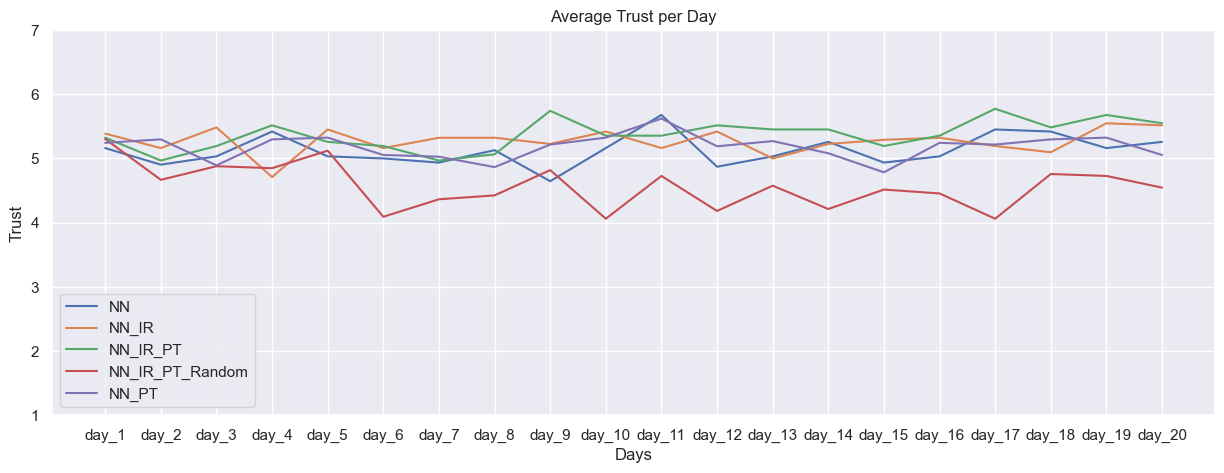

In [384]:
# calculate and plot average trust per day for each model
for model in models_names:
    last_rate_model = last_rate.loc[model_indexes[model]]
    last_rate_model_mean = last_rate_model.mean()
    p = sns.lineplot(x=last_rate.columns, y=last_rate_model_mean, 
                     dashes=False, markers=True, label=model)

p.set(ylim=(1, 7), title='Average Trust per Day', ylabel='Trust', xlabel='Days')
plt.show()

## Users actions according to system predictions

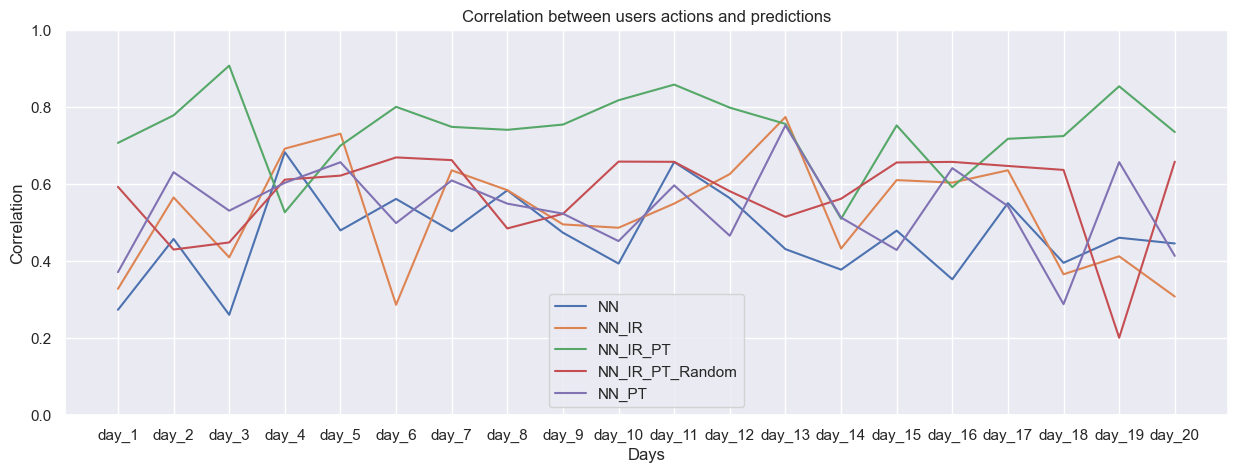

In [385]:
# calculate and plot correlation between model prediction and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes[model]]
    first_rate_model = first_rate.loc[model_indexes[model]]
    cors = preds_model.corrwith(first_rate_model, method='pearson')
    p = sns.lineplot(x=cors.index, y=cors, dashes=False, markers=True, label=model)

p.set(ylim=(0,1), title='Correlation between users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

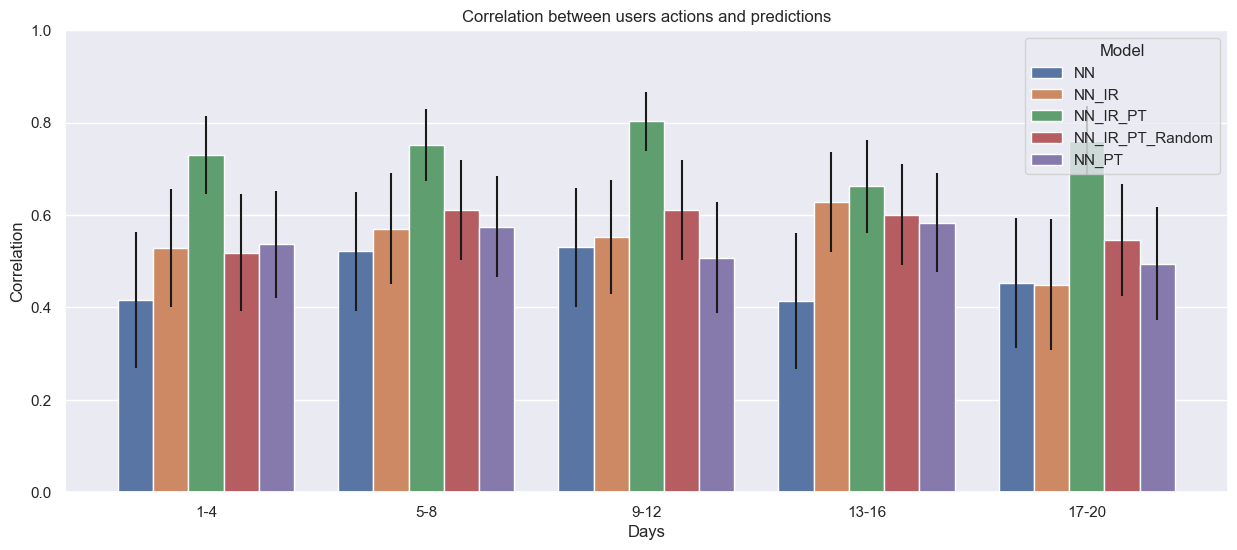

In [386]:
# calculate and plot correlation between model prediction and first_rate for each model
df_corr_ci = pd.DataFrame({'Model': [], 'Correlation': [], 'CI Lower': [], 'CI Upper': [], 'Day': []})

num_days_in_group = 4
grouped_days = [preds.columns[i:i+num_days_in_group] for i in range(0, len(preds.columns), num_days_in_group)]
grouped_days_names = ['1-4', '5-8', '9-12', '13-16', '17-20']

for i, model in enumerate(models_names):
    preds_model = preds.loc[model_indexes[model]]
    grouped_preds_model = pd.DataFrame()
    for group in grouped_days:
        grouped_preds_model = pd.concat([grouped_preds_model, preds_model[group].apply(list, axis=1)], axis=1)
    grouped_preds_model.columns = grouped_days_names
    grouped_preds_model = grouped_preds_model.explode(grouped_days_names)
    
    first_rate_model = first_rate.loc[model_indexes[model]]
    grouped_first_rate_model = pd.DataFrame()
    for group in grouped_days:
        grouped_first_rate_model = pd.concat([grouped_first_rate_model, first_rate_model[group].apply(list, axis=1)], axis=1)
    grouped_first_rate_model.columns = grouped_days_names
    grouped_first_rate_model = grouped_first_rate_model.explode(grouped_days_names)

    correlations, ci_lower, ci_upper = calculate_corr_ci(grouped_preds_model, grouped_first_rate_model)
    new_rows = pd.DataFrame({'Correlation': correlations, 'CI Lower': ci_lower, 'CI Upper': ci_upper, 'Model': model, 'Day': grouped_preds_model.columns})
    df_corr_ci = pd.concat([df_corr_ci, new_rows], ignore_index=True)

df_corr_ci['errorbar'] = (df_corr_ci['CI Upper'] - df_corr_ci['CI Lower'])/2

plt.figure(figsize=(15, 6))  
ax = sns.barplot(data=df_corr_ci, x='Day', y='Correlation', hue='Model')#, errorbar=('ci', 0.9), edgecolor='black')
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
ax.errorbar(x=x_coords, y=y_coords, yerr=df_corr_ci['errorbar'], fmt="none", c="k")

ax.set(ylim=(0, 1), title='Correlation between users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

## Statistical significance on correlations

### All data

In [387]:
cors = pd.DataFrame(columns=models_names)
print('Correlation:')

# create dataframe of correlations between model predictions and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes[model]]
    preds_model = preds_model.drop(columns=['day_1'])
    first_rate_model = first_rate.loc[model_indexes[model]]
    first_rate_model = first_rate_model.drop(columns=['day_1'])

    # create series of all rows in preds_model and first_rate_model
    preds_model_all = pd.Series(preds_model.values.ravel())
    first_rate_model_all = pd.Series(first_rate_model.values.ravel())

    # calculate correlation between preds_model_all and first_rate_model_all
    cors_model = preds_model_all.corr(first_rate_model_all, method='pearson')
    print(f'{model} correlation: {cors_model}')
    
    # # calculate average distance of preds_model_all from 50
    # preds_model_all_dist = preds_model_all.apply(lambda x: abs(x - 50))
    # print(f'{model} extreme: {preds_model_all_dist.mean()}')
    # print()

Correlation:
NN correlation: 0.47743173220189206
NN_IR correlation: 0.5548477189676133
NN_IR_PT correlation: 0.7437293482365002
NN_IR_PT_Random correlation: 0.577435365517941
NN_PT correlation: 0.5493518503285121


### Per user

In [388]:
cors = pd.DataFrame(columns=models_names)

# create dataframe of correlations between model predictions and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes[model]]
    preds_model = preds_model.drop(columns=['day_1'])
    first_rate_model = first_rate.loc[model_indexes[model]]
    first_rate_model = first_rate_model.drop(columns=['day_1'])
    cors_model = preds_model.corrwith(first_rate_model, axis=1, method='pearson')
    cors_model = cors_model.dropna(how='any')
    cors[model] = cors_model.reset_index(drop=True)

# remove Nans
cors = cors.dropna(how='any')

In [389]:
print('Mean Correlation per User:')
print(cors.mean())
print()

# check statistical significance between models with two tails t-test
print('Statistical Significance:')
for i in range(len(models_names)):
    for j in range(i+1, len(models_names)):
        model1 = models_names[i]
        model2 = models_names[j]
        t_statistic, p_value = stats.f_oneway(cors[model1], cors[model2])
        print(f'{model1} vs {model2}: f_statistic={t_statistic}, p_value={p_value}')

Mean Correlation per User:
NN                 0.472682
NN_IR              0.509008
NN_IR_PT           0.741450
NN_IR_PT_Random    0.507336
NN_PT              0.488306
dtype: float64

Statistical Significance:
NN vs NN_IR: f_statistic=0.09431322627444333, p_value=0.759944986057548
NN vs NN_IR_PT: f_statistic=6.534230244139745, p_value=0.013427888847184944
NN vs NN_IR_PT_Random: f_statistic=0.08412187656388401, p_value=0.7728982380799543
NN vs NN_PT: f_statistic=0.016274959096496212, p_value=0.898960519650283
NN_IR vs NN_IR_PT: f_statistic=4.513209509535692, p_value=0.03822864537001455
NN_IR vs NN_IR_PT_Random: f_statistic=0.0001839167364894408, p_value=0.9892297292484086
NN_IR vs NN_PT: f_statistic=0.02692905917564397, p_value=0.8702645149088261
NN_IR_PT vs NN_IR_PT_Random: f_statistic=4.472029911512166, p_value=0.039085470336202945
NN_IR_PT vs NN_PT: f_statistic=4.93746479218689, p_value=0.03049099122904544
NN_IR_PT_Random vs NN_PT: f_statistic=0.02235610897614966, p_value=0.8817006901

## Statistical significance on trust

In [390]:
trust = pd.DataFrame(columns=models_names)

# create dataframe of avg trust of users for each model
for model in models_names:
    last_rate_model = last_rate.loc[model_indexes[model]]
    last_rate_model = last_rate_model.mean(axis=1)
    trust[model] = last_rate_model.reset_index(drop=True)

# trust = trust.dropna(how='any')

In [403]:
print('Mean Trust per User:')
print(trust.mean())
print()

# check statistical significance between models with repeated measures ANOVA
print('Statistical Significance:')
for i in range(len(models_names)):
    for j in range(i+1, len(models_names)):
        model1 = models_names[i]
        model2 = models_names[j]
        f_statistic, p_value = stats.f_oneway(trust[model1], trust[model2])
        print(f'{model1} vs {model2}: f_statistic={f_statistic}, p_value={p_value}')

Mean Trust per User:
NN                 5.018421
NN_IR              5.207895
NN_IR_PT           5.397368
NN_IR_PT_Random    4.063158
NN_PT              4.889474
dtype: float64

Statistical Significance:
NN vs NN_IR: f_statistic=0.44424977623735984, p_value=0.5093276883486119
NN vs NN_IR_PT: f_statistic=2.654189125766217, p_value=0.11199819372373909
NN vs NN_IR_PT_Random: f_statistic=9.288155637878772, p_value=0.0043032806417831375
NN vs NN_PT: f_statistic=0.21830359848867503, p_value=0.6431513266557989
NN_IR vs NN_IR_PT: f_statistic=0.3971027568069045, p_value=0.5325691337800751
NN_IR vs NN_IR_PT_Random: f_statistic=9.739418617285924, p_value=0.0035448283091714656
NN_IR vs NN_PT: f_statistic=0.9015147368709117, p_value=0.3487068180534879
NN_IR_PT vs NN_IR_PT_Random: f_statistic=16.506892615055285, p_value=0.00025083987111120036
NN_IR_PT vs NN_PT: f_statistic=3.0078596743080164, p_value=0.09141826291309871
NN_IR_PT_Random vs NN_PT: f_statistic=5.256179548995101, p_value=0.02781878319126

---
## Participants Errors

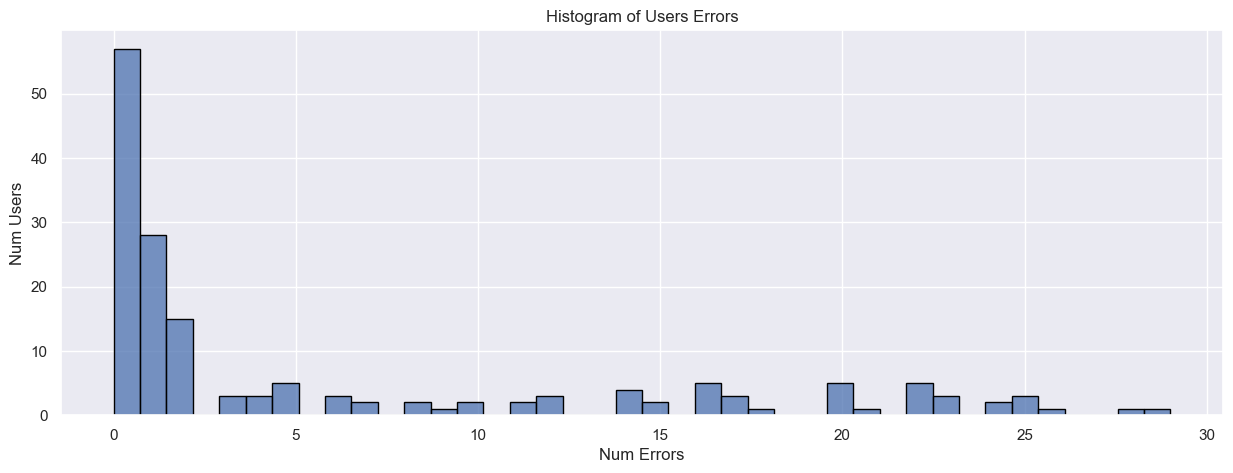

In [392]:
# calculate participants' errors
users_label_error = (labels != label_test).sum(axis=1)
users_pred_error = pred_test.apply(lambda x: (abs(x - preds.loc[x.name]) > 5).sum(), axis=1)
users_error = users_label_error + users_pred_error

# plot histogram of participants' error
p = sns.histplot(users_error, bins=40, edgecolor='black')
p.set(title='Histogram of Users Errors', xlabel='Num Errors', ylabel='Num Users')
plt.show()

---
## Analysis of good participants

In [393]:
allowed_errors = 10

good_users_idx = users_error[users_error <= allowed_errors].index
print(f'Number of users with less than {allowed_errors} errors is: {len(good_users_idx)}')
# sort from high to low users error in the range index of 100 to 206
# print(users_error[100:206].sort_values(ascending=False).head(10))

Number of users with less than 10 errors is: 121


Get every model indexes

In [394]:
# get good users
users_good = users.loc[good_users_idx]
model_indexes_good = {}

# get indexes of every model name
for model in models_names:
    model_indexes_good[model] = users_good.index[users_good['model_name'] == model].tolist()

## Average good users trust in the system

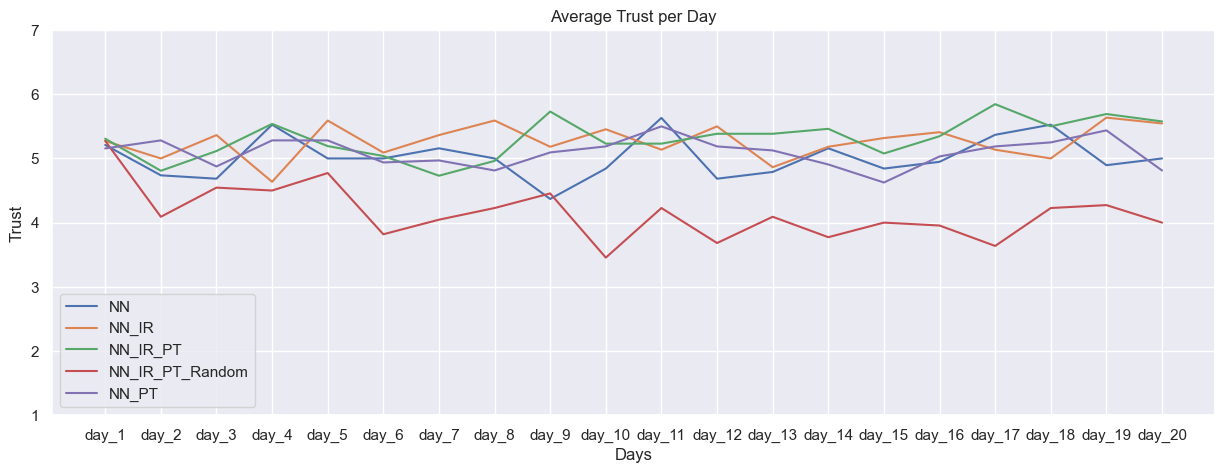

In [395]:
# calculate and plot average trust per day for each model
for model in models_names:
    last_rate_model = last_rate.loc[model_indexes_good[model]]
    last_rate_model_mean = last_rate_model.mean()
    p = sns.lineplot(x=last_rate.columns, y=last_rate_model_mean, 
                     dashes=False, markers=True, label=model)

p.set(ylim=(1, 7), title='Average Trust per Day', ylabel='Trust', xlabel='Days')
plt.show()

## Good users actions according to system predictions

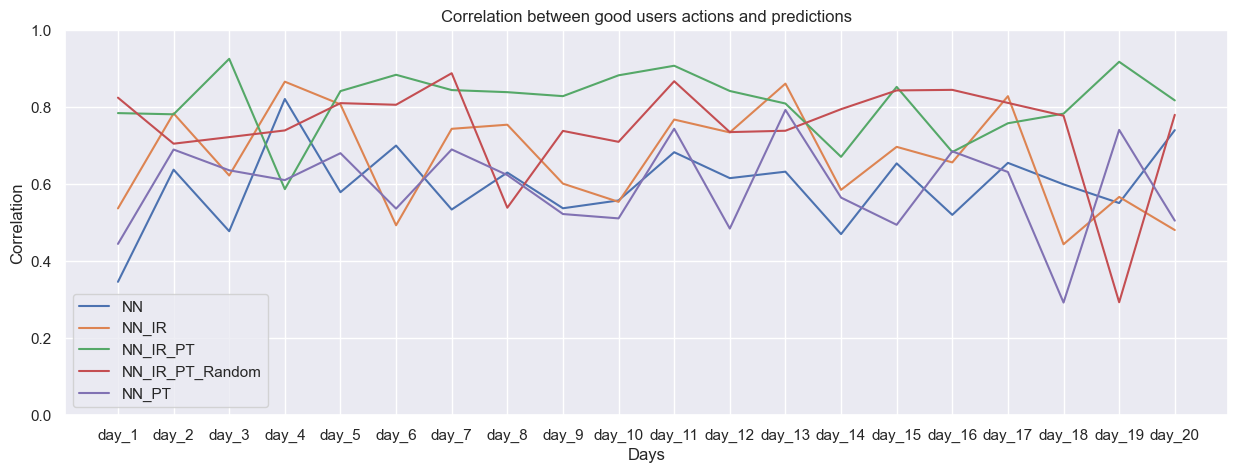

In [396]:
# calculate and plot correlation between model prediction and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes_good[model]]
    first_rate_model = first_rate.loc[model_indexes_good[model]]
    cors = preds_model.corrwith(first_rate_model, method='pearson')
    p = sns.lineplot(x=cors.index, y=cors, dashes=False, markers=True, label=model)

p.set(ylim=(0,1), title='Correlation between good users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

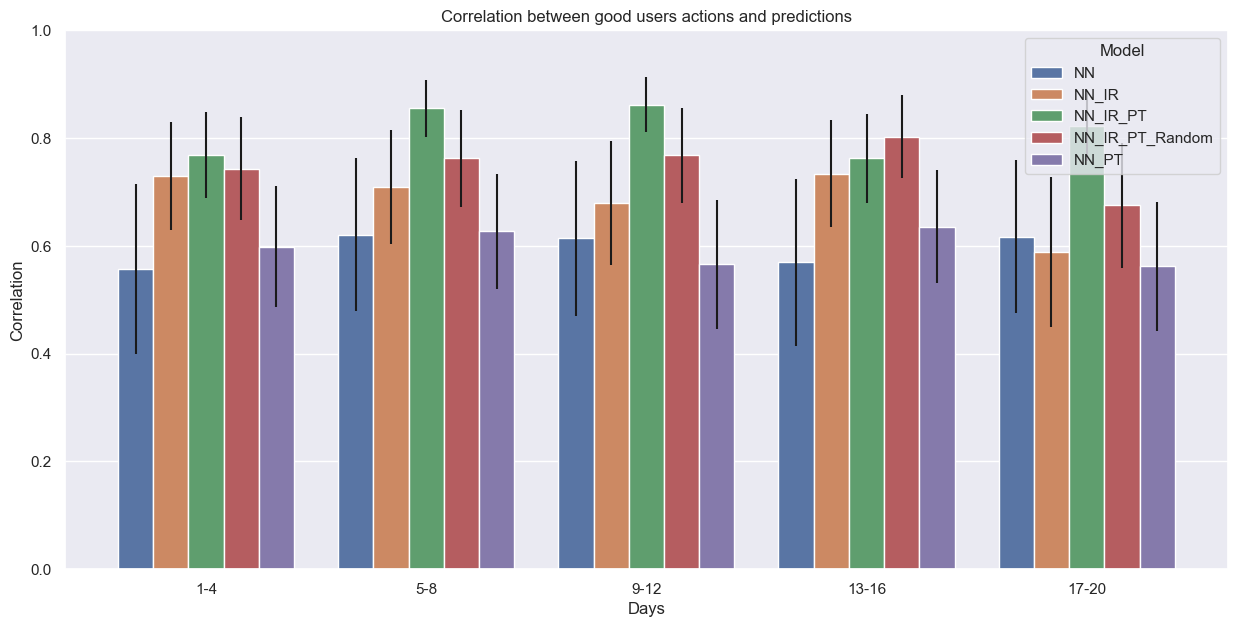

In [397]:
# calculate and plot correlation between model prediction and first_rate for each model
df_corr_ci = pd.DataFrame({'Model': [], 'Correlation': [], 'CI Lower': [], 'CI Upper': [], 'Day': []})

num_days_in_group = 4
grouped_days = [preds.columns[i:i+num_days_in_group] for i in range(0, len(preds.columns), num_days_in_group)]
grouped_days_names = ['1-4', '5-8', '9-12', '13-16', '17-20']

for i, model in enumerate(models_names):
    preds_model = preds.loc[model_indexes_good[model]]
    grouped_preds_model = pd.DataFrame()
    for group in grouped_days:
        grouped_preds_model = pd.concat([grouped_preds_model, preds_model[group].apply(list, axis=1)], axis=1)
    grouped_preds_model.columns = grouped_days_names
    grouped_preds_model = grouped_preds_model.explode(grouped_days_names)
    
    first_rate_model = first_rate.loc[model_indexes_good[model]]
    grouped_first_rate_model = pd.DataFrame()
    for group in grouped_days:
        grouped_first_rate_model = pd.concat([grouped_first_rate_model, first_rate_model[group].apply(list, axis=1)], axis=1)
    grouped_first_rate_model.columns = grouped_days_names
    grouped_first_rate_model = grouped_first_rate_model.explode(grouped_days_names)

    correlations, ci_lower, ci_upper = calculate_corr_ci(grouped_preds_model, grouped_first_rate_model)
    new_rows = pd.DataFrame({'Correlation': correlations, 'CI Lower': ci_lower, 'CI Upper': ci_upper, 'Model': model, 'Day': grouped_preds_model.columns})
    df_corr_ci = pd.concat([df_corr_ci, new_rows], ignore_index=True)

df_corr_ci['errorbar'] = (df_corr_ci['CI Upper'] - df_corr_ci['CI Lower'])/2

plt.figure(figsize=(15, 7))
ax = sns.barplot(data=df_corr_ci, x='Day', y='Correlation', hue='Model')#, errorbar=('ci', 0.9), edgecolor='black')
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
ax.errorbar(x=x_coords, y=y_coords, yerr=df_corr_ci['errorbar'], fmt="none", c="k")

ax.set(ylim=(0, 1), title='Correlation between good users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

## Check statistical significance on correlations

### All data

In [398]:
cors = pd.DataFrame(columns=models_names)

# create dataframe of correlations between model predictions and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes_good[model]]
    preds_model = preds_model.drop(columns=['day_1'])
    first_rate_model = first_rate.loc[model_indexes_good[model]]
    first_rate_model = first_rate_model.drop(columns=['day_1'])

    # create series of all rows in preds_model and first_rate_model
    preds_model_all = pd.Series(preds_model.values.ravel())
    first_rate_model_all = pd.Series(first_rate_model.values.ravel())

    # calculate correlation between preds_model_all and first_rate_model_all
    cors_model = preds_model_all.corr(first_rate_model_all, method='pearson')
    print(f'{model} correlation: {cors_model}')
    
    # # calculate average distance of preds_model_all from 50
    # preds_model_all_dist = preds_model_all.apply(lambda x: abs(x - 50))
    # print(f'{model} extreme: {preds_model_all_dist.mean()}')
    # print()

NN correlation: 0.6106480985179439
NN_IR correlation: 0.692973548657138
NN_IR_PT correlation: 0.8161555685957204
NN_IR_PT_Random correlation: 0.74629898082753
NN_PT correlation: 0.6063511114517002


### Per user

In [399]:
cors = pd.DataFrame(columns=models_names)

# create dataframe of correlations between model predictions and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes_good[model]]
    preds_model = preds_model.drop(columns=['day_1'])
    first_rate_model = first_rate.loc[model_indexes_good[model]]
    first_rate_model = first_rate_model.drop(columns=['day_1'])
    cors_model = first_rate_model.corrwith(preds_model, axis=1, method='pearson')
    cors_model = cors_model.dropna(how='any')
    cors[model] = cors_model.reset_index(drop=True)

cors = cors.dropna(how='any')

In [400]:
print(cors.mean())
print()

# check statistical significance between models with two tails t-test
for i in range(len(models_names)):
    for j in range(i+1, len(models_names)):
        model1 = models_names[i]
        model2 = models_names[j]
        t_statistic, p_value = stats.f_oneway(cors[model1], cors[model2])
        print(f'{model1} vs {model2}: f_statistic={t_statistic}, p_value={p_value}')

NN                 0.629663
NN_IR              0.714520
NN_IR_PT           0.851410
NN_IR_PT_Random    0.699774
NN_PT              0.611471
dtype: float64

NN vs NN_IR: f_statistic=0.3694735293949607, p_value=0.547330365438682
NN vs NN_IR_PT: f_statistic=3.822759923147397, p_value=0.05882125038448354
NN vs NN_IR_PT_Random: f_statistic=0.2558447253366105, p_value=0.6162532236829112
NN vs NN_PT: f_statistic=0.014419745868091204, p_value=0.9051247905238793
NN_IR vs NN_IR_PT: f_statistic=1.7366812033446206, p_value=0.19637071982128493
NN_IR vs NN_IR_PT_Random: f_statistic=0.012685724285718349, p_value=0.9109855501878563
NN_IR vs NN_PT: f_statistic=0.5086101476759642, p_value=0.48060777697171997
NN_IR_PT vs NN_IR_PT_Random: f_statistic=2.1869102345749227, p_value=0.148394087430155
NN_IR_PT vs NN_PT: f_statistic=4.039346913710125, p_value=0.05244012690512344
NN_IR_PT_Random vs NN_PT: f_statistic=0.3784680644243579, p_value=0.5425203271214292


## Check statistical significance on trust

In [401]:
trust = pd.DataFrame(columns=models_names)

# create dataframe of avg trust of users for each model
for model in models_names:
    last_rate_model = last_rate.loc[model_indexes_good[model]]
    last_rate_model = last_rate_model.mean(axis=1)
    trust[model] = last_rate_model.reset_index(drop=True)

In [402]:
print(trust.mean())
print()

# check statistical significance between models with repeated measures ANOVA
for i in range(len(models_names)):
    for j in range(i+1, len(models_names)):
        model1 = models_names[i]
        model2 = models_names[j]
        f_statistic, p_value = stats.f_oneway(trust[model1], trust[model2])
        print(f'{model1} vs {model2}: f_statistic={f_statistic}, p_value={p_value}')

NN                 5.018421
NN_IR              5.207895
NN_IR_PT           5.397368
NN_IR_PT_Random    4.063158
NN_PT              4.889474
dtype: float64

NN vs NN_IR: f_statistic=0.44424977623735984, p_value=0.5093276883486119
NN vs NN_IR_PT: f_statistic=2.654189125766217, p_value=0.11199819372373909
NN vs NN_IR_PT_Random: f_statistic=9.288155637878772, p_value=0.0043032806417831375
NN vs NN_PT: f_statistic=0.21830359848867503, p_value=0.6431513266557989
NN_IR vs NN_IR_PT: f_statistic=0.3971027568069045, p_value=0.5325691337800751
NN_IR vs NN_IR_PT_Random: f_statistic=9.739418617285924, p_value=0.0035448283091714656
NN_IR vs NN_PT: f_statistic=0.9015147368709117, p_value=0.3487068180534879
NN_IR_PT vs NN_IR_PT_Random: f_statistic=16.506892615055285, p_value=0.00025083987111120036
NN_IR_PT vs NN_PT: f_statistic=3.0078596743080164, p_value=0.09141826291309871
NN_IR_PT_Random vs NN_PT: f_statistic=5.256179548995101, p_value=0.02781878319126592
